# Analisi Frequenza Risultati
Questo notebook analizza la distribuzione dei risultati delle partite salvate nel database.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import logging

# Aggiungiamo la root del progetto al path per importare db_module
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import db_module

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
sns.set_theme(style="whitegrid")
%matplotlib inline

### Configurazione UTENTE

In [35]:
# Se True, mostra la distribuzione di TUTTI i risultati frequenti.
# Se False, monitora solo la % del TARGET_SCORE scelto.
ANALYZE_ALL = True

# Imposta il risultato specifico (es: "2-1", "1-1") - Usato se ANALYZE_ALL = False
TARGET_SCORE = "2-4" 

# Quanti dei risultati più comuni mostrare nel grafico globale
TOP_N_SCORES = 20

# FILTRO CAMPIONATI: Inserisci i nomi dei campionati da analizzare (es: ["Serie A", "Ligue 1"])
# Se lasci la lista vuota [], verranno analizzati TUTTI i campionati.
LEAGUE_FILTER = ['Serie A', 'Serie B', 'Premier League', 'Bundesliga']

# FILTRO RISULTATI: Inserisci i risultati specifici da analizzare (es: ["1-1", "2-1"])
# Se lasci la lista vuota [], verranno analizzati TUTTI i risultati.
SCORE_FILTER = []

### Opzioni Disponibili (Campionati e Risultati)
Esegui questa cella per vedere i nomi esatti dei campionati e i risultati più frequenti da copiare nei filtri sopra.

In [36]:
conn = db_module.create_connection()
if conn:
    try:
        # 1. Campionati
        query_leagues = "SELECT DISTINCT tournament FROM matches ORDER BY tournament ASC;"
        leagues = pd.read_sql(query_leagues, conn)
        print(f"--- Trovati {len(leagues)} campionati ---")
        pd.set_option('display.max_rows', 100) 
        display(leagues.head(100)) # Mostriamo i primi 100
        
        # 2. Risultati Frequenti
        query_scores = """
            SELECT home_score || '-' || away_score as score, COUNT(*) as occorrenze
            FROM matches
            WHERE home_score != 'N/A' AND away_score != 'N/A'
            GROUP BY score ORDER BY occorrenze DESC LIMIT 20;
        """
        scores = pd.read_sql(query_scores, conn)
        print("\n--- Top 20 Risultati più comuni nel DB ---")
        display(scores)
    finally:
        conn.close()

--- Trovati 110 campionati ---


C:\Users\nicol\AppData\Local\Temp\ipykernel_66656\1764753512.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  leagues = pd.read_sql(query_leagues, conn)


,tournament
0,1. Lig
1,1. MFL
2,1st Division
3,2. Bundesliga
4,3. Liga
5,"AFC Champions League Elite, East"
6,"AFC Champions League Elite, West"
7,"AFC Champions League Two, Group A"
8,"AFC Champions League Two, Group B"
9,"AFC Champions League Two, Group C"



--- Top 20 Risultati più comuni nel DB ---


C:\Users\nicol\AppData\Local\Temp\ipykernel_66656\1764753512.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  scores = pd.read_sql(query_scores, conn)


,score,occorrenze
0,1-1,56
1,1-2,46
2,1-0,41
3,0-1,39
4,2-1,38
5,0-0,34
6,2-0,33
7,3-1,31
8,3-0,25
9,0-2,24


### Caricamento Dati

In [37]:
def fetch_match_results(leagues=None, scores=None):
    conn = db_module.create_connection()
    if not conn:
        return None
    
    try: 
        query = """
            SELECT 
                id,
                tournament,
                home_team,
                away_team,
                CAST(NULLIF(home_score, 'N/A') AS INTEGER) as home, 
                CAST(NULLIF(away_score, 'N/A') AS INTEGER) as away,
                home_score || '-' || away_score as score_string
            FROM matches
            WHERE home_score IS NOT NULL AND away_score IS NOT NULL 
              AND home_score != 'N/A' AND away_score != 'N/A'
        """
        
        # Filtro campionati
        if leagues and len(leagues) > 0:
            league_list = ", ".join([f"'{l}'" for l in leagues])
            query += f" AND tournament IN ({league_list})"
            
        # Filtro risultati
        if scores and len(scores) > 0:
            score_list = ", ".join([f"'{s}'" for s in scores])
            query += f" AND (home_score || '-' || away_score) IN ({score_list})"
            
        df = pd.read_sql(query, conn)
        return df
    finally:
        conn.close()

df = fetch_match_results(LEAGUE_FILTER, SCORE_FILTER)
print(f"Match caricati: {len(df)}")
df.head()

C:\Users\nicol\AppData\Local\Temp\ipykernel_66656\289872336.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Match caricati: 43


,id,tournament,home_team,away_team,home,away,score_string
0,12436498,Premier League,Chelsea,Aston Villa,3,0,3-0
1,12436505,Premier League,Manchester United,Everton,4,0,4-0
2,12436507,Premier League,Tottenham Hotspur,Fulham,1,1,1-1
3,12436504,Premier League,Liverpool,Manchester City,2,0,2-0
4,12504665,Serie A,Udinese,Genoa,0,2,0-2


### Analisi e Visualizzazione delle ricorrenze dei risultati

2026-02-02 14:50:39,944 - INFO - Analisi della frequenza dei risultati selezionati (Top 20)...


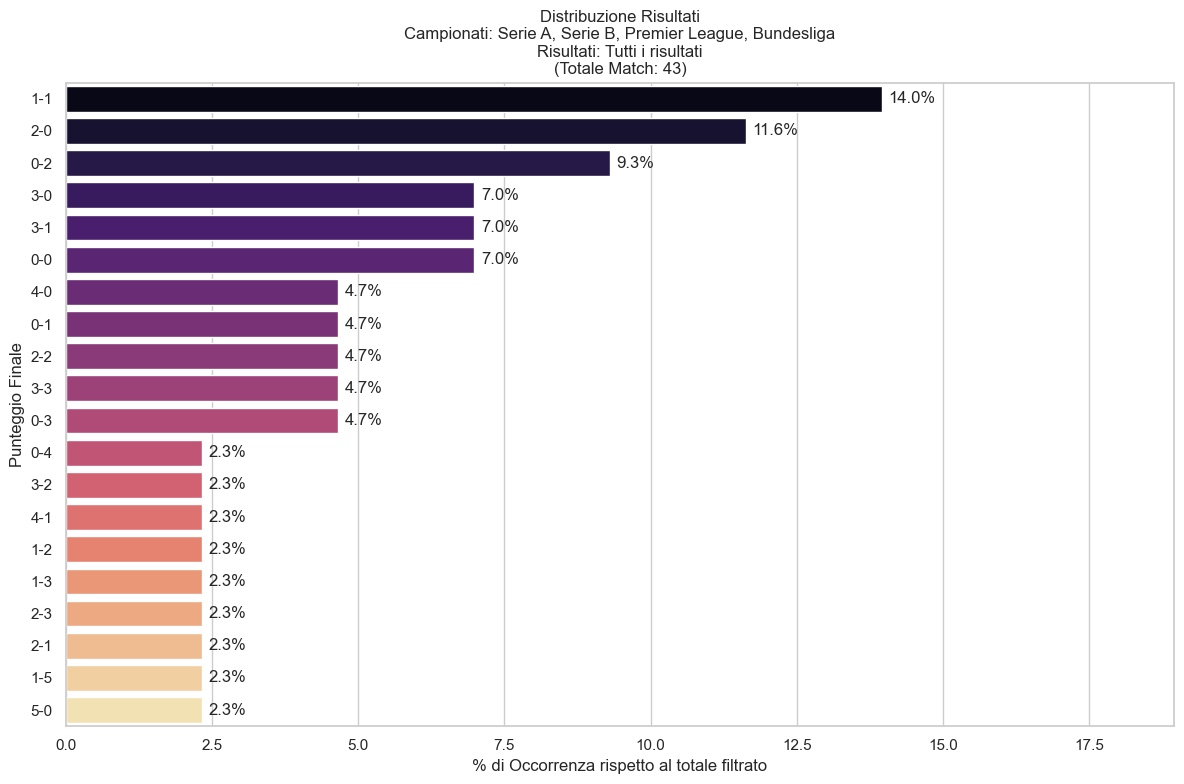

In [38]:
if df is None or df.empty:
    print("Nessun dato trovato per i criteri selezionati.")
else:
    total_matches = len(df)
    plt.figure(figsize=(12, 8))
    
    # Costruzione descrizione filtri per il titolo
    l_desc = "Tutti i campionati" if not LEAGUE_FILTER else ", ".join(LEAGUE_FILTER)
    s_desc = "Tutti i risultati" if not SCORE_FILTER else ", ".join(SCORE_FILTER)
    filter_desc = f"Campionati: {l_desc}\nRisultati: {s_desc}"

    if ANALYZE_ALL or SCORE_FILTER:
        logging.info(f"Analisi della frequenza dei risultati selezionati (Top {TOP_N_SCORES})...")
        
        score_counts = df['score_string'].value_counts()
        score_percentages = (score_counts / total_matches) * 100
        
        # Se abbiamo pochi risultati filtrati, mostriamoli tutti invece di limitare a TOP_N
        n_to_show = min(len(score_percentages), TOP_N_SCORES)
        top_analysis = score_percentages.head(n_to_show).reset_index()
        top_analysis.columns = ['score_string', 'percentage']

        ax = sns.barplot(x='percentage', y='score_string', data=top_analysis, palette='magma', hue='score_string', legend=False)
        
        for p in ax.patches:
            width = p.get_width()
            ax.annotate(f'{width:.1f}%', (width, p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', xytext=(5, 0), textcoords='offset points')

        plt.title(f'Distribuzione Risultati\n{filter_desc}\n(Totale Match: {total_matches})', fontsize=12)
        plt.xlabel('% di Occorrenza rispetto al totale filtrato')
        plt.ylabel('Punteggio Finale')
        plt.xlim(0, top_analysis['percentage'].max() + 5)
    else:
        # Analisi singola se non c'è filtro e non è ANALYZE_ALL (vecchio comportamento)
        logging.info(f"Analisi della frequenza globale per il risultato {TARGET_SCORE}...")
        target_count = len(df[df['score_string'] == TARGET_SCORE])
        percentage = (target_count / total_matches) * 100
        
        plt.bar([TARGET_SCORE], [percentage], color='skyblue')
        plt.text(0, percentage + 0.1, f'{percentage:.2f}%', ha='center', fontsize=12)
        
        plt.title(f'Frequenza del Risultato {TARGET_SCORE}\n{filter_desc}', fontsize=12)
        plt.ylabel('% di Occorrenza')
        plt.ylim(0, max(percentage + 1, 5))

    plt.tight_layout()
    plt.show()

### Lista Completa Match Filtrati
Qui puoi vedere l'elenco dei singoli match che corrispondono ai filtri impostati sopra.

In [39]:
# Visualizza tutti i match che passano i filtri
if df is not None and not df.empty:
    # Possiamo anche aggiungere una ricerca testuale rapida qui
    SEARCH_TEAM = "" # Inserisci parte del nome di una squadra per filtrare ulteriormente
    
    display_df = df.copy()
    if SEARCH_TEAM:
        display_df = display_df[
            (display_df['home_team'].str.contains(SEARCH_TEAM, case=False)) | 
            (display_df['away_team'].str.contains(SEARCH_TEAM, case=False))
        ]
    
    print(f"Visualizzando {len(display_df)} match:")
    display(display_df[['tournament', 'home_team', 'away_team', 'score_string']])
else:
    print("Nessun match da visualizzare.")

Visualizzando 43 match:


,tournament,home_team,away_team,score_string
0,Premier League,Chelsea,Aston Villa,3-0
1,Premier League,Manchester United,Everton,4-0
2,Premier League,Tottenham Hotspur,Fulham,1-1
3,Premier League,Liverpool,Manchester City,2-0
4,Serie A,Udinese,Genoa,0-2
5,Serie A,Parma,Lazio,3-1
6,Serie A,Torino,Napoli,0-1
7,Serie A,Lecce,Juventus,1-1
8,Serie A,Roma,Atalanta,0-2
9,Bundesliga,1. FSV Mainz 05,TSG Hoffenheim,2-0
